In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
df=pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")

In [4]:
df.shape

(200, 5)

In [5]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [7]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [8]:
df["Gender"].value_counts()

Gender
Female    112
Male       88
Name: count, dtype: int64

In [9]:
df["Annual Income (k$)"].max()

137

In [10]:
df["Annual Income (k$)"].min()

15

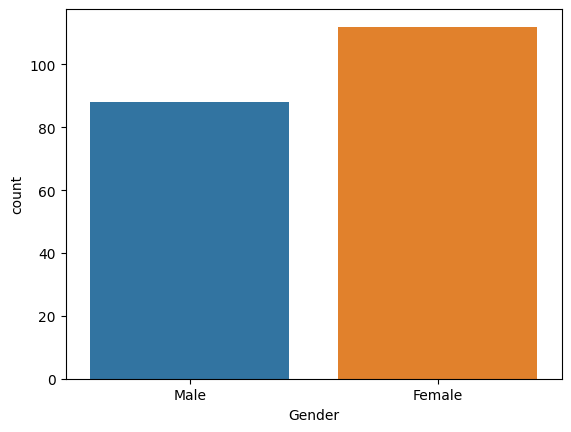

In [11]:
sns.countplot(x='Gender', data=df)
plt.show()

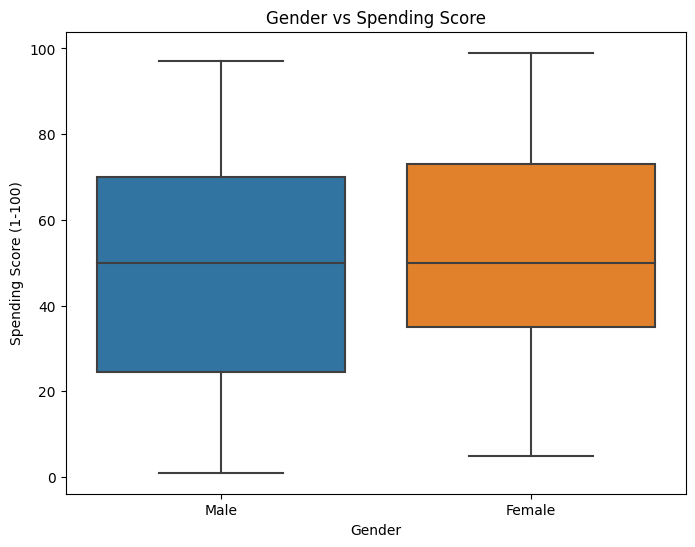

In [12]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=df)
plt.title("Gender vs Spending Score")
plt.show()


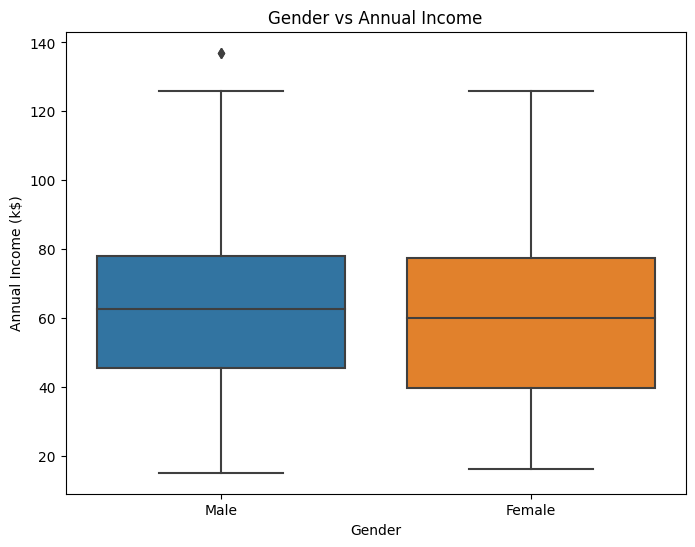

In [13]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Gender', y='Annual Income (k$)', data=df)
plt.title("Gender vs Annual Income")
plt.show()


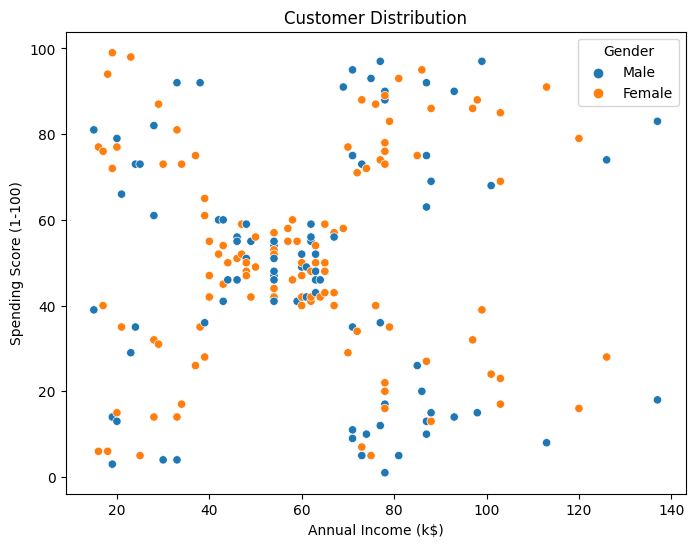

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue='Gender')
plt.title("Customer Distribution")
plt.show()


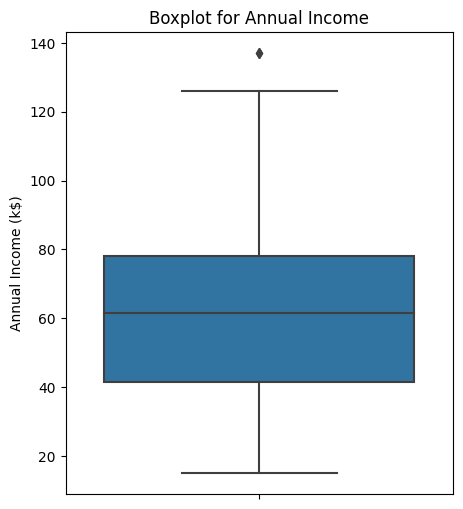

In [15]:
plt.figure(figsize=(5,6))
sns.boxplot(y='Annual Income (k$)', data=df)
plt.title("Boxplot for Annual Income")
plt.show()


In [16]:
Q1 = df['Annual Income (k$)'].quantile(0.25)
Q3 = df['Annual Income (k$)'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = df[(df['Annual Income (k$)'] < lower_bound) | (df['Annual Income (k$)'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")
print(outliers[['CustomerID','Annual Income (k$)']])


Number of outliers: 2
     CustomerID  Annual Income (k$)
198         199                 137
199         200                 137


In [17]:
df= df[(df['Annual Income (k$)'] >= lower_bound) & (df['Annual Income (k$)'] <= upper_bound)]
print(f"Original data size: {len(df)}")
print(f"Data size after removing outliers: {len(df)}")


Original data size: 198
Data size after removing outliers: 198


In [18]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
193,194,Female,38,113,91
194,195,Female,47,120,16
195,196,Female,35,120,79
196,197,Female,45,126,28


In [19]:
from sklearn.preprocessing import LabelEncoder


In [20]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

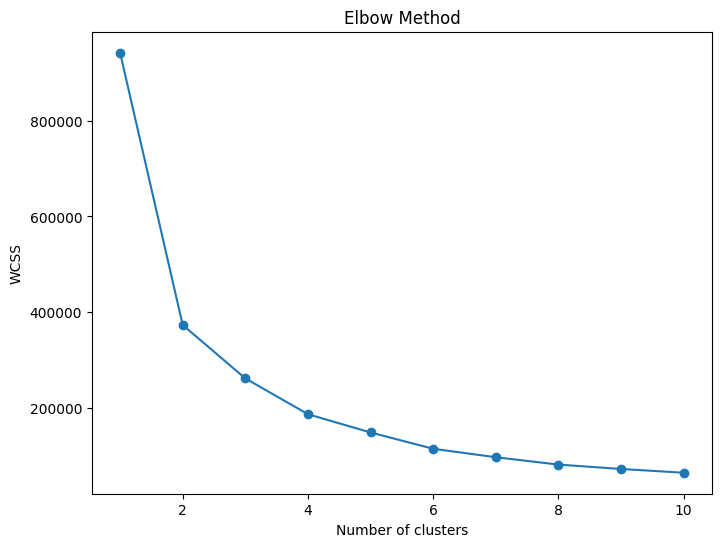

In [21]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8,6))
plt.plot(range(1,11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


from above k =4

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

kmeans_scaled = KMeans(n_clusters=5, init='k-means++', random_state=42)
y_scaled = kmeans_scaled.fit_predict(X_scaled)

df['Cluster'] = y_scaled


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


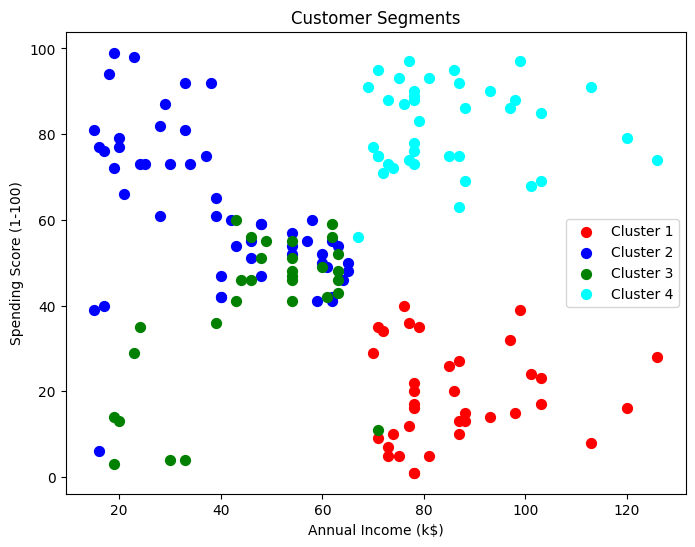

In [23]:
plt.figure(figsize=(8,6))
colors = ['red','blue','green','cyan']

for i in range(4):
    plt.scatter(df[df['Cluster']==i]['Annual Income (k$)'],
                df[df['Cluster']==i]['Spending Score (1-100)'],
                s=50, c=colors[i], label=f'Cluster {i+1}')

plt.title('Customer Segments')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()


In [24]:
cluster_summary = df.groupby('Cluster')[['Age','Annual Income (k$)','Spending Score (1-100)']].mean()
print(cluster_summary)


               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        40.111111           86.055556               18.861111
1        24.673077           39.500000               61.807692
2        56.000000           47.266667               39.566667
3        32.615385           84.743590               81.435897
4        49.487805           47.878049               41.048780


In [25]:
print(df['Cluster'].value_counts())


Cluster
1    52
4    41
3    39
0    36
2    30
Name: count, dtype: int64


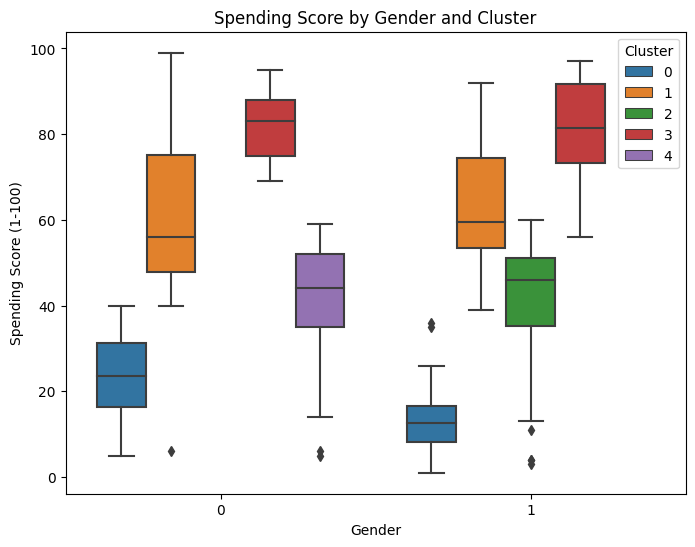

In [26]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=df, hue='Cluster')
plt.title("Spending Score by Gender and Cluster")
plt.show()


In [27]:
# Step 1: Create cluster summary
cluster_summary = df.groupby('Cluster').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean'
}).round(1)

print("Cluster Summary (Numerical):")
print(cluster_summary)

# Step 2: Map clusters to labels (based on avg income & spending)
def label_cluster(row):
    if row['Annual Income (k$)'] < cluster_summary['Annual Income (k$)'].mean() and row['Spending Score (1-100)'] < cluster_summary['Spending Score (1-100)'].mean():
        return "Budget Customers"
    elif row['Annual Income (k$)'] > cluster_summary['Annual Income (k$)'].mean() and row['Spending Score (1-100)'] > cluster_summary['Spending Score (1-100)'].mean():
        return "Premium Customers"
    elif row['Annual Income (k$)'] < cluster_summary['Annual Income (k$)'].mean() and row['Spending Score (1-100)'] > cluster_summary['Spending Score (1-100)'].mean():
        return "Impulsive/Young Spenders"
    else:
        return "Savers/Conservative Customers"

# Step 3: Apply labels
df['Cluster_Label'] = df['Cluster'].apply(lambda x: label_cluster(cluster_summary.loc[x]))

# Step 4: New cluster summary with labels
labeled_summary = df.groupby('Cluster_Label').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Number of Customers'}).round(1)

print("\nCluster Summary with Labels:")
print(labeled_summary)


Cluster Summary (Numerical):
          Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                  
0        40.1                86.1                    18.9
1        24.7                39.5                    61.8
2        56.0                47.3                    39.6
3        32.6                84.7                    81.4
4        49.5                47.9                    41.0

Cluster Summary with Labels:
                                Age  Annual Income (k$)  \
Cluster_Label                                             
Budget Customers               52.2                47.6   
Impulsive/Young Spenders       24.7                39.5   
Premium Customers              32.6                84.7   
Savers/Conservative Customers  40.1                86.1   

                               Spending Score (1-100)  Number of Customers  
Cluster_Label                                                               
Budget Customers          

In [28]:
from sklearn.metrics import silhouette_score

X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
score = silhouette_score(X, df['Cluster'])
print("Silhouette Score:", score)


Silhouette Score: 0.2062297355240466
